# AI agent for interacting with a Structured Query Language database¶

In [ ]:
## installing libraries
!pip install langgraph langchain_community langchain_openai langchain_groq

In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
google_api_key=os.getenv("GOOGLE_API_KEY")
groq_api_key=os.getenv("GROQ_API_KEY")

### 0. Create your own DB

In [1]:
import sqlite3

# Step 1: Create a connection to the SQLite database (or create one if it doesn't exist)
connection = sqlite3.connect("employee.db")  # Creates 'example.db' if it doesn't exist

# Step 2: Create a cursor object to execute SQL commands
cursor = connection.cursor()

# Step 3: Create a table
table_creation_query = """
CREATE TABLE IF NOT EXISTS employees (
    emp_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    hire_date TEXT NOT NULL,
    salary REAL NOT NULL
);
"""
cursor.execute(table_creation_query)

# Step 4: Insert rows into the table
insert_query = """
INSERT INTO employees (emp_id, first_name, last_name, email, hire_date, salary)
VALUES (?, ?, ?, ?, ?, ?);
"""

# Data to insert
rows_to_insert = [
    (1, "Sunny", "Savita", "sunny.sv@abc.com", "2023-06-01", 50000.00),
    (2, "Arhun", "Meheta", "arhun.m@gmail.com", "2022-04-15", 60000.00),
    (3, "Alice", "Johnson", "alice.johnson@jpg.com", "2021-09-30", 55000.00),
    (4, "Bob", "Brown", "bob.brown@uio.com", "2020-01-20", 45000.00),
]

# Insert each row
cursor.executemany(insert_query, rows_to_insert)

# Step 5: Commit the transaction
connection.commit()

# Step 6: Fetch and print rows to verify
cursor.execute("SELECT * FROM employees;")
for row in cursor.fetchall():
    print(row)

# Step 7: Close the connection
connection.close()


(1, 'Sunny', 'Savita', 'sunny.sv@abc.com', '2023-06-01', 50000.0)
(2, 'Arhun', 'Meheta', 'arhun.m@gmail.com', '2022-04-15', 60000.0)
(3, 'Alice', 'Johnson', 'alice.johnson@jpg.com', '2021-09-30', 55000.0)
(4, 'Bob', 'Brown', 'bob.brown@uio.com', '2020-01-20', 45000.0)


### 1. Fetch the available tables from the database

In [3]:
import sqlite3
from langchain_community.utilities import SQLDatabase

# Step 1: Connect to the SQLite Database and Check Tables
conn = sqlite3.connect('northwind.db')  # Use the downloaded file path here
cursor = conn.cursor()

# Query to check available tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in Northwind Database:", tables)

# Example Query: Fetching first 10 rows from 'Customers' table
cursor.execute("SELECT * FROM Customers LIMIT 10;")
rows = cursor.fetchall()
print("First 10 rows from Customers table:")
for row in rows:
    print(row)

# Step 2: Use LangChain to interact with the database
# Using SQLDatabase from LangChain to query the Northwind.db
db = SQLDatabase.from_uri("sqlite:///Northwind.db")

# Print the dialect (sqlite) and available tables
print("Dialect:", db.dialect)
print("Usable tables:", db.get_usable_table_names())

# Example Query: Fetching first 10 rows from 'Employees' table
query_result = db.run("SELECT * FROM Employees LIMIT 10;")
print("Query result from Employees table:", query_result)


Tables in Northwind Database: [('Categories',), ('sqlite_sequence',), ('CustomerCustomerDemo',), ('CustomerDemographics',), ('Customers',), ('Employees',), ('EmployeeTerritories',), ('Order Details',), ('Orders',), ('Products',), ('Regions',), ('Shippers',), ('Suppliers',), ('Territories',)]
First 10 rows from Customers table:
('ALFKI', 'Alfreds Futterkiste', 'Maria Anders', 'Sales Representative', 'Obere Str. 57', 'Berlin', 'Western Europe', '12209', 'Germany', '030-0074321', '030-0076545')
('ANATR', 'Ana Trujillo Emparedados y helados', 'Ana Trujillo', 'Owner', 'Avda. de la Constitución 2222', 'México D.F.', 'Central America', '05021', 'Mexico', '(5) 555-4729', '(5) 555-3745')
('ANTON', 'Antonio Moreno Taquería', 'Antonio Moreno', 'Owner', 'Mataderos  2312', 'México D.F.', 'Central America', '05023', 'Mexico', '(5) 555-3932', None)
('AROUT', 'Around the Horn', 'Thomas Hardy', 'Sales Representative', '120 Hanover Sq.', 'London', 'British Isles', 'WA1 1DP', 'UK', '(171) 555-7788', '(17

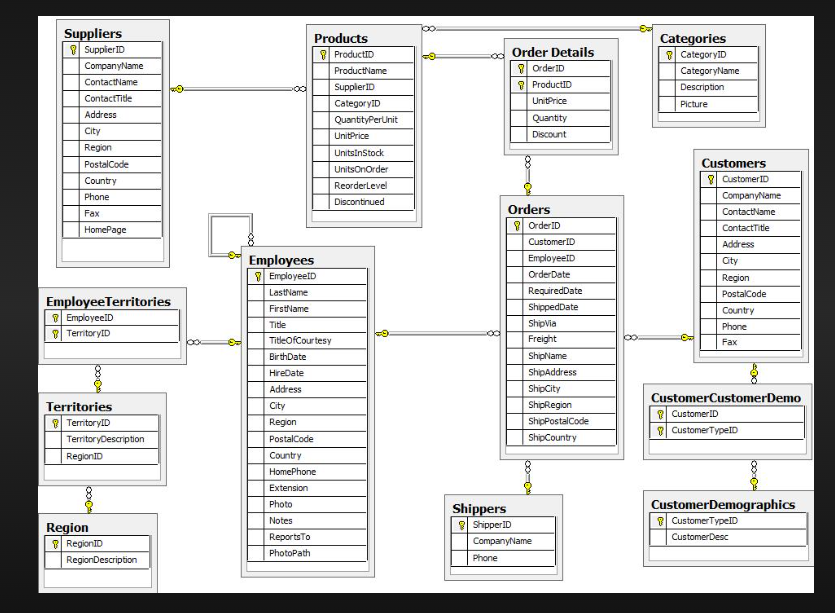

### 2. Creating toolnode functions to handle errors in agents

In [4]:
from typing import Any

# Import necessary components from langchain and langgraph libraries.
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback mechanism to handle errors and return them as a message.
    - `tools`: A list of tools that the ToolNode will use.
    - The fallback is triggered in case of an exception during tool execution.
    
    Returns:
        RunnableWithFallbacks: A ToolNode wrapped with a fallback mechanism.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    """
    Handle errors that occur during tool execution and format them into a message.
    - `state`: Contains the current state, including the error and tool calls.
    
    Returns:
        dict: A dictionary with formatted messages, each containing error details.
    """
    error = state.get("error")  # Extract the error from the state.
    tool_calls = state["messages"][-1].tool_calls  # Get the tool calls from the last message.
    
    # Construct and return error messages for each tool call, including the error message.
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",  # Error message.
                tool_call_id=tc["id"],  # Tool call ID for reference.
            )
            for tc in tool_calls  # Iterate over all tool calls and generate a message for each.
        ]
    }


### 3. Fetch the DDL for the relevant tables 


We will define a few tools that the agent will use to interact with the database.

`list_tables_tool`: Fetch the available tables from the database

`get_schema_tool`: Fetch the DDL for a table

`db_query_tool`: Execute the query and fetch the results OR return an error message if the query fails
For the first two tools, we will grab them from the SQLDatabaseToolkit, also available in the langchain_community package.

In [5]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit 
from langchain_openai import ChatOpenAI 
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI



# llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
llm=ChatGroq(model="llama3-70b-8192")
# Initialize the SQLDatabaseToolkit with a database connection (db) and the Groq Llama model.
# This toolkit provides tools for interacting with SQL databases using a language model.
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

# Retrieve the list of tools available within the toolkit, which include functions for interacting with the database.
tools = toolkit.get_tools()

# Extract the specific tools: 
# - 'sql_db_list_tables' for listing the tables in the database.
# - 'sql_db_schema' for retrieving the schema of a specific table.
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# Invoke the list_tables_tool with an empty string to get the list of all tables in the database.
# The result will be a list of table names in the database.
print(list_tables_tool.invoke(""))

# Invoke the get_schema_tool with the argument "Artist" to retrieve the schema of the 'Artist' table.
# This should return metadata about the 'Artist' table, such as column names and their types.
print(get_schema_tool.invoke("Customers"))


Categories, CustomerCustomerDemo, CustomerDemographics, Customers, EmployeeTerritories, Employees, Order Details, Orders, Products, Regions, Shippers, Suppliers, Territories

CREATE TABLE "Customers" (
	"CustomerID" TEXT, 
	"CompanyName" TEXT, 
	"ContactName" TEXT, 
	"ContactTitle" TEXT, 
	"Address" TEXT, 
	"City" TEXT, 
	"Region" TEXT, 
	"PostalCode" TEXT, 
	"Country" TEXT, 
	"Phone" TEXT, 
	"Fax" TEXT, 
	PRIMARY KEY ("CustomerID")
)

/*
3 rows from Customers table:
CustomerID	CompanyName	ContactName	ContactTitle	Address	City	Region	PostalCode	Country	Phone	Fax
ALFKI	Alfreds Futterkiste	Maria Anders	Sales Representative	Obere Str. 57	Berlin	Western Europe	12209	Germany	030-0074321	030-0076545
ANATR	Ana Trujillo Emparedados y helados	Ana Trujillo	Owner	Avda. de la Constitución 2222	México D.F.	Central America	05021	Mexico	(5) 555-4729	(5) 555-3745
ANTON	Antonio Moreno Taquería	Antonio Moreno	Owner	Mataderos  2312	México D.F.	Central America	05023	Mexico	(5) 555-3932	None
*/


 For the `db_query_tool`, we will execute the query against the database and return the results.

In [6]:
from langchain_core.tools import tool  # Import the @tool decorator from langchain_core.

# Define a custom tool using the @tool decorator to execute a SQL query against the database.
@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and return the result.
    If the query is invalid or returns no result, an error message will be returned.
    In case of an error, the user is advised to rewrite the query and try again.
    
    Parameters:
        query (str): The SQL query to execute.
    
    Returns:
        str: The result of the query or an error message if the query fails.
    """
    # Execute the query on the database without throwing an exception if it fails.
    result = db.run_no_throw(query)
    
    # Check if the query result is empty or failed (None or False).
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    
    # If the query is successful, return the result.
    return result

# Test the custom tool with a sample SQL query to select 10 rows from the 'Artist' table.
print(db_query_tool.invoke("SELECT * FROM Employees LIMIT 10;"))


[(1, 'Davolio', 'Nancy', 'Sales Representative', 'Ms.', '1968-12-08', '2012-05-01', '507 - 20th Ave. E.Apt. 2A', 'Seattle', 'North America', '98122', 'USA', '(206) 555-9857', '5467', b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00d\x00d\x00\x00\xff\xec\x00\x11Ducky\x00\x01\x00\x04\x00\x00\x00N\x00\x00\xff\xee\x00&Adobe\x00d\xc0\x00\x00\x00\x01\x03\x00\x15\x04\x03\x06\n\r\x00\x00\r\xc7\x00\x00\x14\xf8\x00\x00\x1f\xc7\x00\x000\x18\xff\xdb\x00\x84\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x03\x04\x03\x02\x03\x04\x05\x03\x03\x03\x03\x05\x05\x04\x04\x05\x04\x04\x05\x07\x05\x06\x06\x06\x06\x05\x07\x07\x08\x08\t\x08\x08\x07\x0b\x0b\x0c\x0c\x0b\x0b\x0c\x0c\x0c\x0c\x0c\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x01\x03\x03\x03\x05\x05\x05\n\x07\x07\n\x0f\x0c\n\x0c\x0f\x12\x0e\x0e\x0e\x0e\x12\x11\x0e\x0e\x0e\x0e\x0e\x11\x11\x0e\x0e\x0e\x0e\x0e\x0e\x11\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\xff\xc2\x00\x11\x08\x00\xaa\x00\xa0\

### 4. Correct mistakes surfaced by the database engine until the query is successful

In [7]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | llm.bind_tools(
    [db_query_tool]
)

query_check.invoke({"messages": [("user", "SELECT * FROM Employees LIMIT 5;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d8g7', 'function': {'arguments': '{"query":"SELECT * FROM Employees LIMIT 5;"}', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 1119, 'total_tokens': 1170, 'completion_time': 0.158667957, 'prompt_time': 0.145927091, 'queue_time': 0.004207617999999996, 'total_time': 0.304595048}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_7ab5f7e105', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-04a121ef-5d05-455b-9400-55fcf65abeff-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Employees LIMIT 5;'}, 'id': 'call_d8g7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1119, 'output_tokens': 51, 'total_tokens': 1170})

### 5. Building the flow using Langgraph

In [8]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages

# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Define a new graph
workflow = StateGraph(State)

# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

workflow.add_node("first_tool_call", first_tool_call)

In [9]:

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = llm.bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)

In [10]:

# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")


# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | llm.bind_tools(
    [SubmitFinalAnswer]
)


def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))


# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

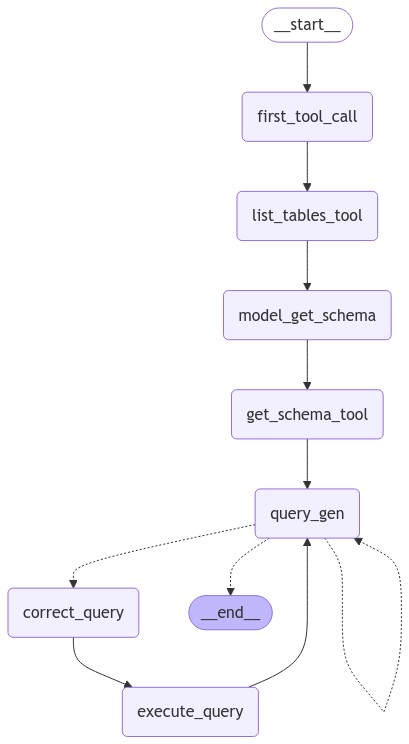

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [14]:
messages = app.invoke(
    {"messages": [("user", "Tell me name of the employee joined last?")]}
)
json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
json_str

'Nancy Davolio'

In [18]:
messages = app.invoke(
    {"messages": [("user", "Tell me name of the most popular product")]}
)
json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
json_str

'Chai'

In [22]:
messages = app.invoke(
    {"messages": [("user", "Which city has maximum customers?")]}
)
json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
json_str

'Berlin'